<a href="https://colab.research.google.com/github/helgadenes/Astroparticle_physics_Yachay/blob/main/Day_1/Galaxies_EPIC_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Galaxies and the large-scale structure of the Universe

This notebook is based on the following SDSSEPO t utorial: https://github.com/ritatojeiro/SDSSEPO/blob/master/AS1001_SDSSEPO.ipynb

In this Notebook, we will use data from the Sloan Digital Sky Survey (SDSS), to explore the relationship between galaxy properties and the large-scale structure of the Universe.

We will find answers to the following questions:

- How are galaxies spatially distributed in the Universe?
- Are galaxies all the same colour?
- Are galaxies all the same shape?
- How are galaxies' colours and shapes related to their spacial distribution?


## SDSS

We will answer the above questions yourself, by exploring one of the largest astronomical dataset in the world - the Sloan Digital Sky Survey (www.sdss.org).

We will interact directly with the data using the astroquesry python package to query the SDSS database, store data in the cloud, and offers seamless integration with python programming tools via notebooks. In practice, this means that we can access and explore the largest astronomical dataset in the world, using only a web browser.

These exercise assume that you are familiar with basic python, dataframe and matplotlib commands.




### Imports

Firstly, we install astroquery and import the neccesary libraries.

In [1]:
!pip install astroquery

In [2]:
# Import Python libraries

import numpy as np                  # standard Python lib for math ops
import pandas                       # data manipulation package
import matplotlib.pyplot as plt     # another graphing package
import os                           # manage local files in your Compute containers

from astroquery.sdss import SDSS
from astroquery.simbad import Simbad

# Python standard-libraries to download data from the web
from urllib.parse import urlencode
from urllib.request import urlretrieve

#only here to display images
from IPython.display import Image

from astropy.io import ascii
from astropy import coordinates as coords
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.constants import c # useful constants
from astropy import units as u # useful for unit conversions
from matplotlib.image import imread

# do *not* show python warnings
import warnings
warnings.filterwarnings('ignore')
print('Settings applied')

Settings applied


## Querying the SDSS database

The SDSS data is stored in a SQL database. **SQL is a language used to communicate with databases via "queries".** For each query command, the database returns an answer. Usually, this is a **subsample of the original database**, though SQL can operate on the data very effectively too.

In this tutorial we will submit queries to the SDSS database to gather the information that we need, and we will use python to operate on, manipulate, and vizualise that data.

An extensive tutorial on how to query the SDSS database is provided here: https://skyserver.sdss.org/dr16/en/help/howto/search/searchhowtohome.aspx .

In short, every SQL command consists of three blocks:
- The **SELECT** block: it defines the quantities that you want your query to return.
- The **FROM** block: it defines which tables of the database you want SQL to look in.
- The **WHERE** block: it defines any constraints on the data that you want to impose.

### Using SQL and astroquery

For the database schema and documentation see https://skyserver.sdss.org/dr18/MoreTools/browser?&&history=shortdescr+Tables+U The following query returns specific information on a sample of galaxies, as a dataframe.


In [3]:
# Find objects in the Sloan Digital Sky Survey's Data Release 18.
#
# Query the Sloan Digital Sky Serveys' Data Release 18.
# For the database schema and documentation see http://skyserver.sdss.org/dr18
#
# This query finds all galaxies with a size (petror90_r) greater than 10 arcseconds, within
# a region of sky with 100 < RA < 250, a redshift between 0.02 and 0.5, and a g-band magnitude brighter than 17.

query = 'SELECT p.objId, p.ra, p.dec, p.petror90_r, p.expAB_r, p.dered_u as u, '
query += 'p.dered_g as g, p.dered_r as r, p.dered_i as i, '
query += 's.z, s.plate, s.mjd, s.fiberid '
query += 'FROM galaxy AS p JOIN SpecObj AS s ON s.bestobjid = p.objid '
query += 'WHERE '
query += 'p.petror90_r > 10'
query += 'AND p.ra between 100 and 250 '
query += 'AND s.z between 0.02 and 0.5 '
query += 'AND  p.g < 17 '

print (query) # useful for debugging

# send query to SDSS
all_gals = SDSS.query_sql(query, data_release=18)

#all_gals

SELECT p.objId, p.ra, p.dec, p.petror90_r, p.expAB_r, p.dered_u as u, p.dered_g as g, p.dered_r as r, p.dered_i as i, s.z, s.plate, s.mjd, s.fiberid FROM galaxy AS p JOIN SpecObj AS s ON s.bestobjid = p.objid WHERE p.petror90_r > 10AND p.ra between 100 and 250 AND s.z between 0.02 and 0.5 AND  p.g < 17 


The dataframe that is returned, which we named all_gals, holds the following quantities (in columns) for each galaxy:

- ra = Right Ascencion coordinate in degrees
- dec = Declination coordinate in degrees
- petror90_r = Radius enclosing 90% of the pertrosian flux in arcseconds. I.e., size of the galaxy in the sky.
- dered_u, dered_g, dered_r, dered_i, dered_z = Magnitudes in 5 optical filters, from the blue to the red, after subtracting the attenuation due to the Milky Way.
- z = Redshift of the galaxy
- plate = Plate number (SDSS used alluminium plates with drilled holes for positioning optical fibers).
- mjd = Date of the observation
- fiberid = Number of the fiber in a given plate. Plates have between 640 and 1000 fibers.

Let's have a look at the first 10 elements of the returned table (dataframe):

In [4]:
all_gals[0:10]

<Table length=10>
       objId               ra              dec        ... plate  mjd  fiberid
       int64            float64          float64      ... int64 int64  int64 
------------------- ---------------- ---------------- ... ----- ----- -------
1237654029256360161 175.107416928242 1.98492885174002 ...  4740 55651      26
1237654029256687839 175.835900084419 2.00240980569035 ...   514 51994     193
1237654029787594866 162.199987045398 2.17786073226018 ...   506 52022     636
1237654029787660428 162.276214298469 2.22414174470611 ...   507 52353     437
1237654029789298868 166.076482258456 2.31343242103092 ...   508 52366     158
1237654029789691934 166.954689208806 2.35664657052737 ...   509 52374     438
1237654029789888654  167.38702550201 2.26106540664357 ...   509 52374     171
1237654029790019657 167.633392674642 2.21225216648561 ...   510 52381     279
1237654029790216376 168.178837729658 2.39314655869861 ...   509 52374     588
1237654029790543963  168.92291864861 2.36844658266558 ...   510 52381     116

## The large scale structure of the Universe

### Exercise:

1. Plot the positions of all galaxies usint plt.scatter(). Remember to add labels and a title to your plot. Given the large number of points, you might want to use marker='.' and s=1.

2. What can you tell from the distribution of galaxies? Are they uniformly distributed on the sky?

(-5.0, 70.0)

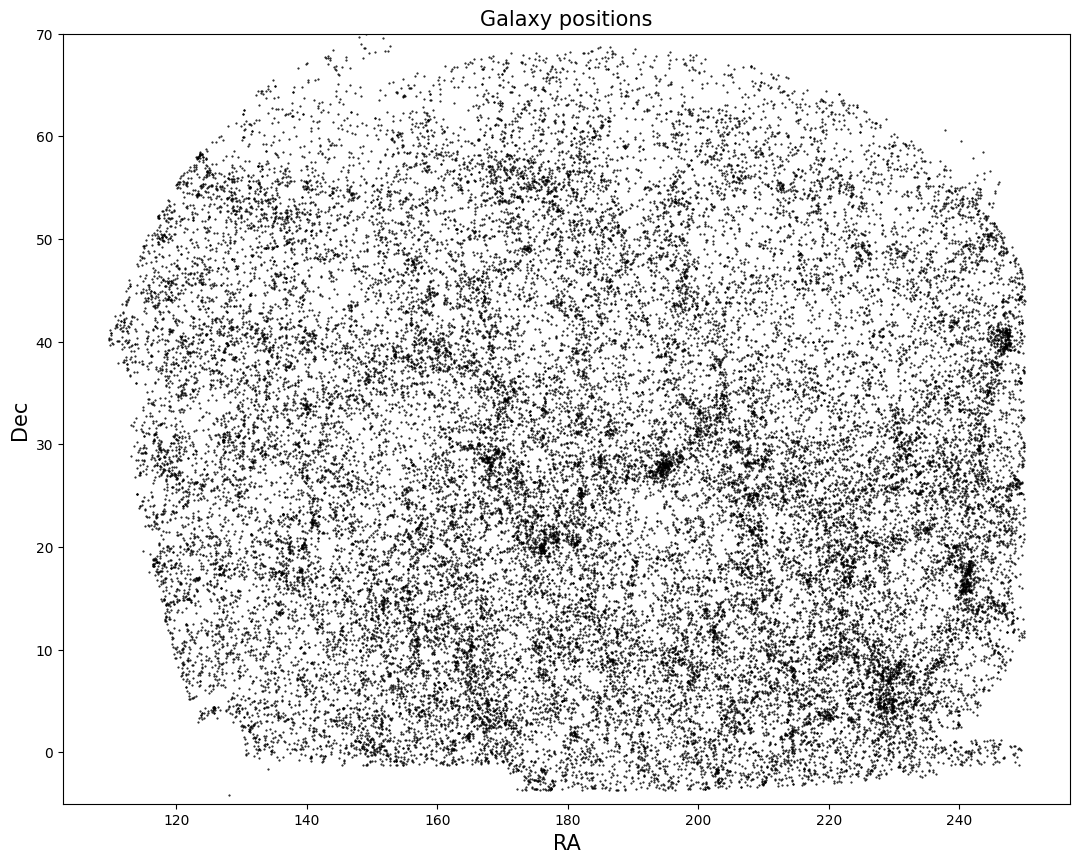

In [5]:
#Possible solution
plt.figure(figsize=(13,10))
plt.scatter(all_gals['ra'], all_gals['dec'], marker='.', color='black',s=1)
plt.xlabel('RA', fontsize=15); plt.ylabel('Dec', fontsize=15)
plt.title('Galaxy positions', fontsize=15)
plt.ylim(-5,70)

The spacial distribution isn't uniform on the sky, with some regions showing a higher density of objects.

### Exercise:

Using the np.where() command, select galaxies in two narrow redshift slices:
- slice 1: 0.02 < z < 0.03 (green)
- slice 2: 0.03 < z < 0.04 (orange)

Make the same plot as above, but only using the galaxies in each slice using the suggested colour scheme (make one plot for each slice). Finally, make a third plot with galaxies from both redshift slices. Add axis labels, a title and an legend to each plot.


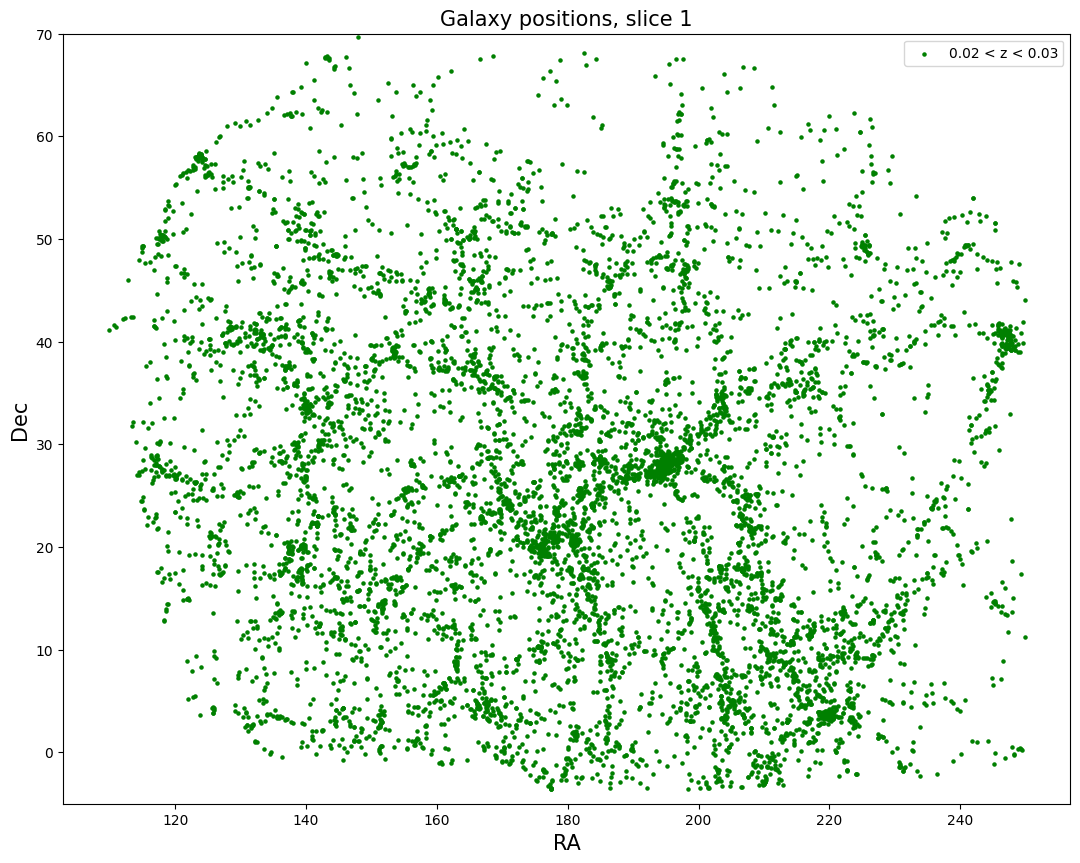

In [6]:
#Possible solution
plt.figure(figsize=(13,10))

slice1 = np.where( (all_gals['z'] > 0.02) & (all_gals['z'] < 0.03))[0]

plt.scatter(all_gals[slice1]['ra'], all_gals[slice1]['dec'], color='green', marker='.', s=20, label='0.02 < z < 0.03')
plt.ylim(-5,70)
plt.xlabel('RA', fontsize=15); plt.ylabel('Dec', fontsize=15)
plt.title('Galaxy positions, slice 1', fontsize=15)
plt.legend()

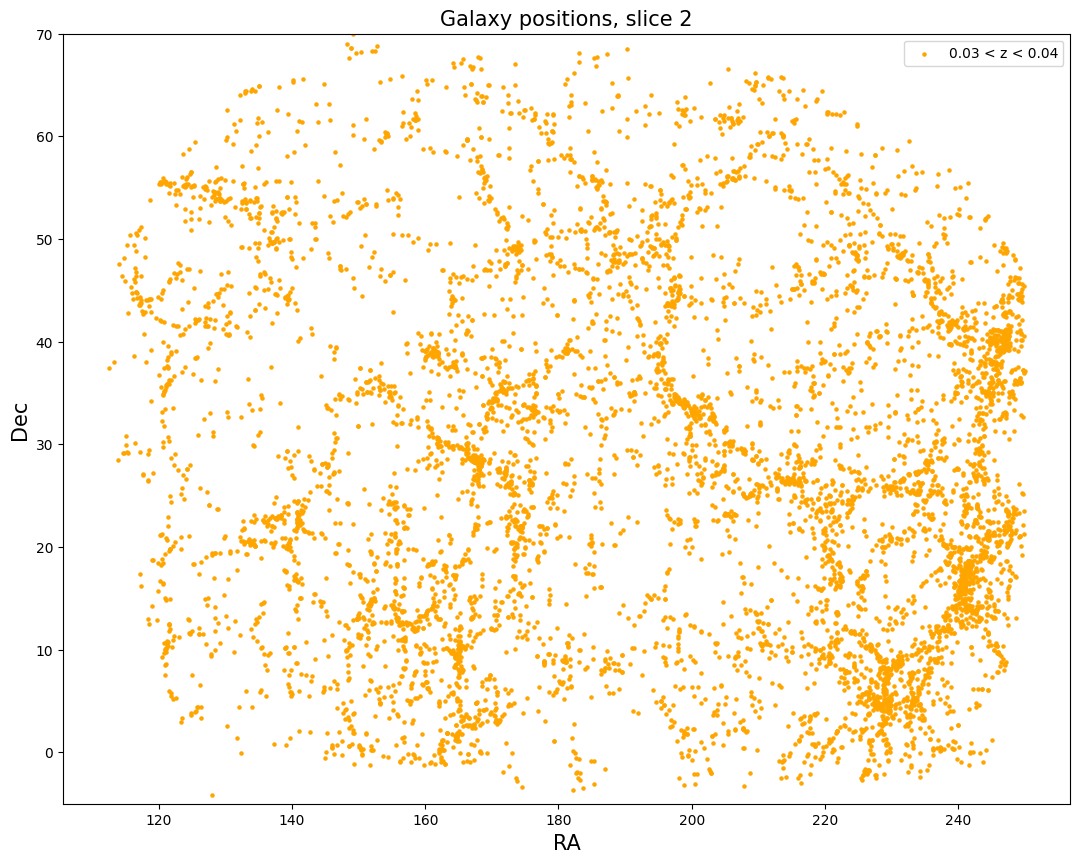

In [7]:
#possible solution
plt.figure(figsize=(13,10))

slice2 = np.where( (all_gals['z'] > 0.03) & (all_gals['z'] < 0.04))[0]

plt.scatter(all_gals[slice2]['ra'], all_gals[slice2]['dec'], color='orange', marker='.', s=20, label='0.03 < z < 0.04')
plt.ylim(-5,70)
plt.xlabel('RA', fontsize=15); plt.ylabel('Dec', fontsize=15)
plt.title('Galaxy positions, slice 2', fontsize=15)
plt.legend()

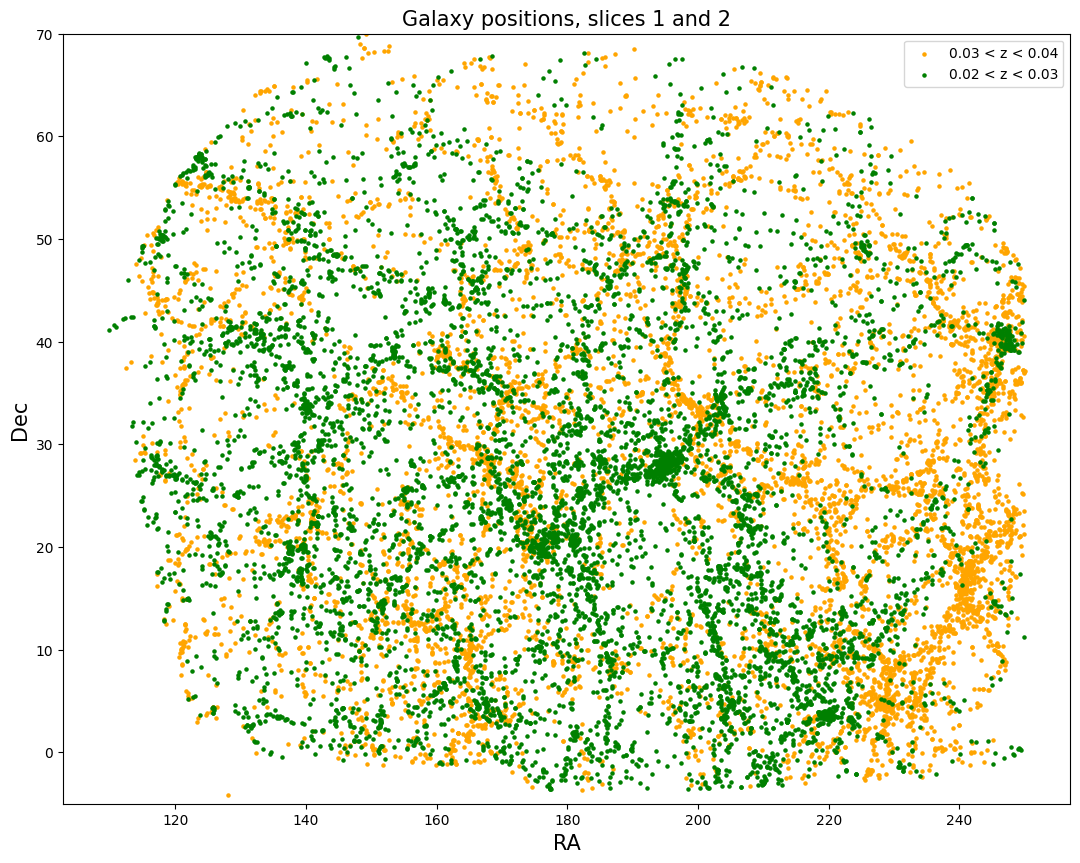

In [8]:
#possible solution
plt.figure(figsize=(13,10))

plt.scatter(all_gals[slice2]['ra'], all_gals[slice2]['dec'], color='orange', marker='.', s=20, label='0.03 < z < 0.04')
plt.scatter(all_gals[slice1]['ra'], all_gals[slice1]['dec'], color='green', marker='.', s=20, label='0.02 < z < 0.03')
plt.xlabel('RA', fontsize=15); plt.ylabel('Dec', fontsize=15)
plt.title('Galaxy positions, slices 1 and 2', fontsize=15)
plt.ylim(-5,70)
plt.legend()

### Exercise:

<b> Do you see more structure in the distribution of galaxies in each slice, when compared to your first plot that included all galaxies?

What can you tell about the structure you see in the two different redshift slices?

Why couldn't you see it in your first plot? </b>

A more filamentary structure connecting regions very high galaxy density (nodes, or knots) is now visible, with clear voids (regions with less galaxies) in between filaments. The filaments in the two redshift slices are often different because we are looking at different regions of space. The reason why filaments and voids becomes more prominent when we look at thin redshift slices is because if we use a wide range in redshift we overlap lots of different filaments and structure, blurring out the Universe's cosmic web.

## Galaxy colours

**Optical colours of galaxies are related to the age of their stars - red galaxies hold older (redder, cooler) stars, whereas blue galaxies tend to have younger (bluer, hotted) stars.** In practice, we can quantify "colour" in Astronomy as _the difference in magnitude in two different bands_.

In this set of exercises **we will focus on the first slice in redshift**, which is very narrow, meaning that all galaxies have a similar redshift. I.e., if galaxies in this redshift slice have different colours, _it ought to be because their spectra and stellar composition are different_, and not because some are redshifted due to the expansion of the Universe.

The following cell plots a histogram of the values of the **u-g colour** of the galaxies in your dataframe:

Text(0.5, 1.0, 'Distribution of u-g color in 0.02 < z < 0.03')

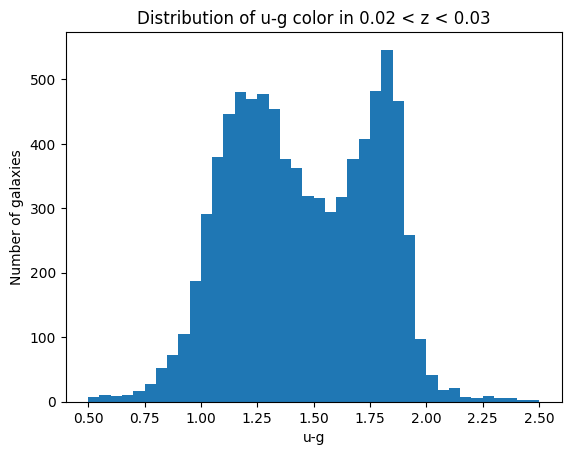

In [9]:

plt.hist(all_gals[slice1]['u']-all_gals[slice1]['g'], bins=40, range=(0.5,2.5))
plt.xlabel('u-g')
plt.ylabel('Number of galaxies')
plt.title('Distribution of u-g color in 0.02 < z < 0.03')

Another way of visialising color this is to plot color against one of the 'r' magnitude, which indicates the stellar mass of the galaxies.

Text(0.5, 1.0, 'u-g color against r magnitude in 0.02 < z < 0.03')

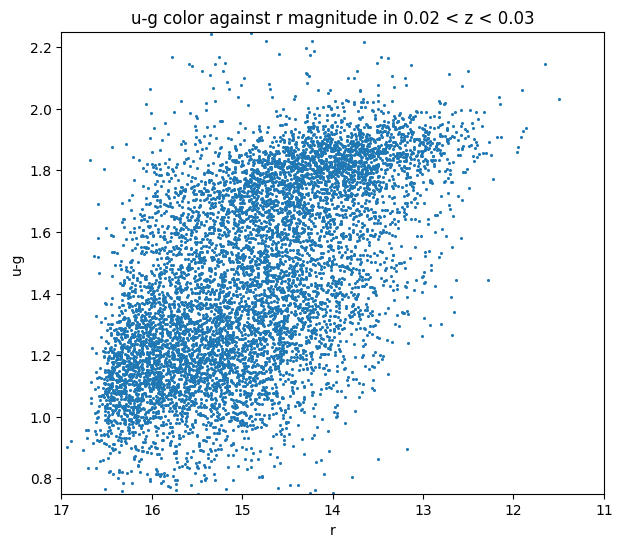

In [10]:
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(1,1,1)
plt.scatter(all_gals[slice1]['r'], all_gals[slice1]['u']-all_gals[slice1]['g'], s=1.5)
plt.xlabel('r')
plt.ylabel('u-g')
ax.set_xlim(11, 17)
ax.set_ylim(0.75,2.25)
ax.invert_xaxis()
plt.title('u-g color against r magnitude in 0.02 < z < 0.03')

Text(0.5, 1.0, 'u-g color against r magnitude in 0.02 < z < 0.03')

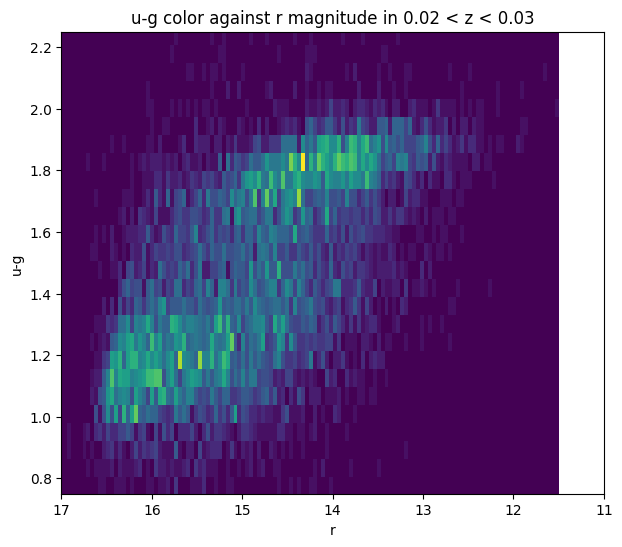

In [11]:
# The same visualisation using a 2D histogram

fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(1,1,1)
ax.hist2d(all_gals[slice1]['r'], all_gals[slice1]['u']-all_gals[slice1]['g'],  bins=200)
plt.xlabel('r')
plt.ylabel('u-g')
ax.set_xlim(11, 17)
ax.set_ylim(0.75,2.25)
ax.invert_xaxis()
plt.title('u-g color against r magnitude in 0.02 < z < 0.03')

### Selecting Galaxies

**np.percentile()** (https://docs.scipy.org/doc/numpy-dev/reference/generated/numpy.percentile.html) allows you to quickly return the percentile of a distribution of points. For example, to find the median (50th percentile) u-g colour of your galaxy population you can write:

In [12]:
median_umg = np.percentile(all_gals[slice1]['u']-all_gals[slice1]['g'], 50)
print(median_umg)

1.4351650000000005


i.e., 50% of the galaxies in your sample have u-g colours that are lower than median_umg (i.e., they are bluer than the median), and 50% have  colours that are larger (i.e., they are redder than the median). If I wanted to choose only the 10% reddest galaxies I could do:

In [13]:
high_umg = np.percentile(all_gals[slice1]['u']-all_gals[slice1]['g'], 90)

very_red_galaxies = np.where((all_gals['z'] > 0.02) & (all_gals['z'] < 0.03) &  (all_gals['u']-all_gals['g'] > high_umg))

### Exercise:

Use np.percentile() to choose the 25% reddest and 25% bluest galaxies in u-g. Then plot their positions on the sky.

**Do both types of galaxies trace the large-scale structure in a similar way?**

What can you say about which galaxies preferencially sit on denser parts of the Universe, and which sit on less dense regions (we call this _environment_)?


In [14]:
#possible answer
low_umg = np.percentile(all_gals[slice1]['u']-all_gals[slice1]['g'], 25)
high_umg = np.percentile(all_gals[slice1]['u']-all_gals[slice1]['g'], 75)

(-5.0, 70.0)

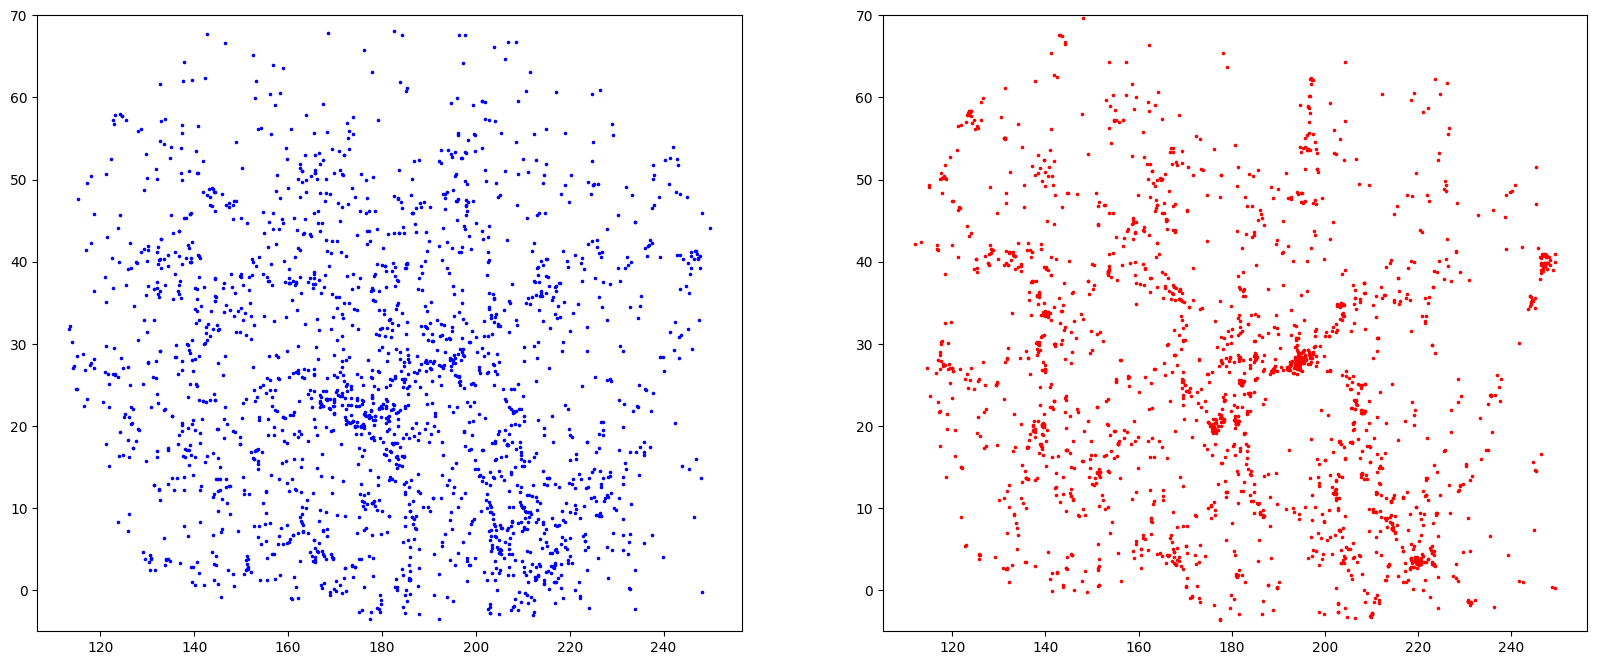

In [15]:
#possible answer
very_red_galaxies = (all_gals['z'] > 0.02) & (all_gals['z'] < 0.03) & (all_gals['u']-all_gals['g'] > high_umg)
very_blue_galaxies = (all_gals['z'] > 0.02) & (all_gals['z'] < 0.03) & (all_gals['u']-all_gals['g'] < low_umg)

plt.figure(figsize=(20,8))
plt.subplot(121)
plt.scatter(all_gals[very_blue_galaxies]['ra'], all_gals[very_blue_galaxies]['dec'],  marker='.', s=10, color='blue')
plt.ylim(-5,70)

plt.subplot(122)
plt.scatter(all_gals[very_red_galaxies]['ra'], all_gals[very_red_galaxies]['dec'],  marker='.', s=10, color='red')
plt.ylim(-5,70)



**Do you see a difference between the two plots?**

By now we have seen how galaxies in general are spacially distributed in the Universe and the shape of the cosmic web, and how galaxies' position on the cosmic web and their environment is related to their colour. Next, we will look at the **shape** of galaxies.

## Galaxy morphology

Galaxy morphology studies the shapes of galaxies.

Here, we will do a more systematic exploration of how galaxy shapes are related to other properties.

The next cell provides a bit of code that selects 16 **random** galaxies from your dataframe, and shows you their optical images.

In [16]:
def show_galaxy_images(my_galaxies):
    #plot a random subset of 16 galaxies
    # set thumbnail parameters
    width=200           # image width
    height=200          # height
    pixelsize=0.396     # image scale
    plt.figure(figsize=(15, 15))   # display in a 4x4 grid
    subPlotNum = 1


    i = 0
    nGalaxies = 16 #Total number of galaxies to plot
    ind = np.random.randint(0,len(my_galaxies), nGalaxies) #randomly selected rows
    count=0
    for i in ind:           # iterate through the randomly selected rows in the DataFrame
        count=count+1
        print('Getting image '+str(count)+' of '+str(nGalaxies)+'...')
        if (count == nGalaxies):
            print('Plotting images...')
        scale=2*all_gals[i]['petror90_r']/pixelsize/width
        pos = coords.SkyCoord(all_gals['ra'][i], all_gals['dec'][i], unit=u.deg, frame='icrs')

        cutoutbaseurl = 'http://skyservice.pha.jhu.edu/DR14/ImgCutout/getjpeg.aspx'
        query_string = urlencode(dict(ra=all_gals['ra'][i], dec=all_gals['dec'][i],width=width, height=height, scale=scale))
        url = cutoutbaseurl + '?' + query_string

        # this downloads the image
        image_name = 'cutout_'+str(i)+'.jpg'
        urlretrieve(url, image_name)

        # Display the image
        img = imread(image_name)

        plt.subplot(4,4,subPlotNum)
        subPlotNum += 1
        plt.imshow(img)                               # show images in grid
        plt.title(i)

You can use the function defined above to plot 16 _random_ galaxies from any dataframe. For example, to plot 16 galaxies randomly selected in a redshift slice 0.02 < z < 0.03 you might do:

Getting image 1 of 16...
Getting image 2 of 16...
Getting image 3 of 16...
Getting image 4 of 16...
Getting image 5 of 16...
Getting image 6 of 16...
Getting image 7 of 16...
Getting image 8 of 16...
Getting image 9 of 16...
Getting image 10 of 16...
Getting image 11 of 16...
Getting image 12 of 16...
Getting image 13 of 16...
Getting image 14 of 16...
Getting image 15 of 16...
Getting image 16 of 16...
Plotting images...


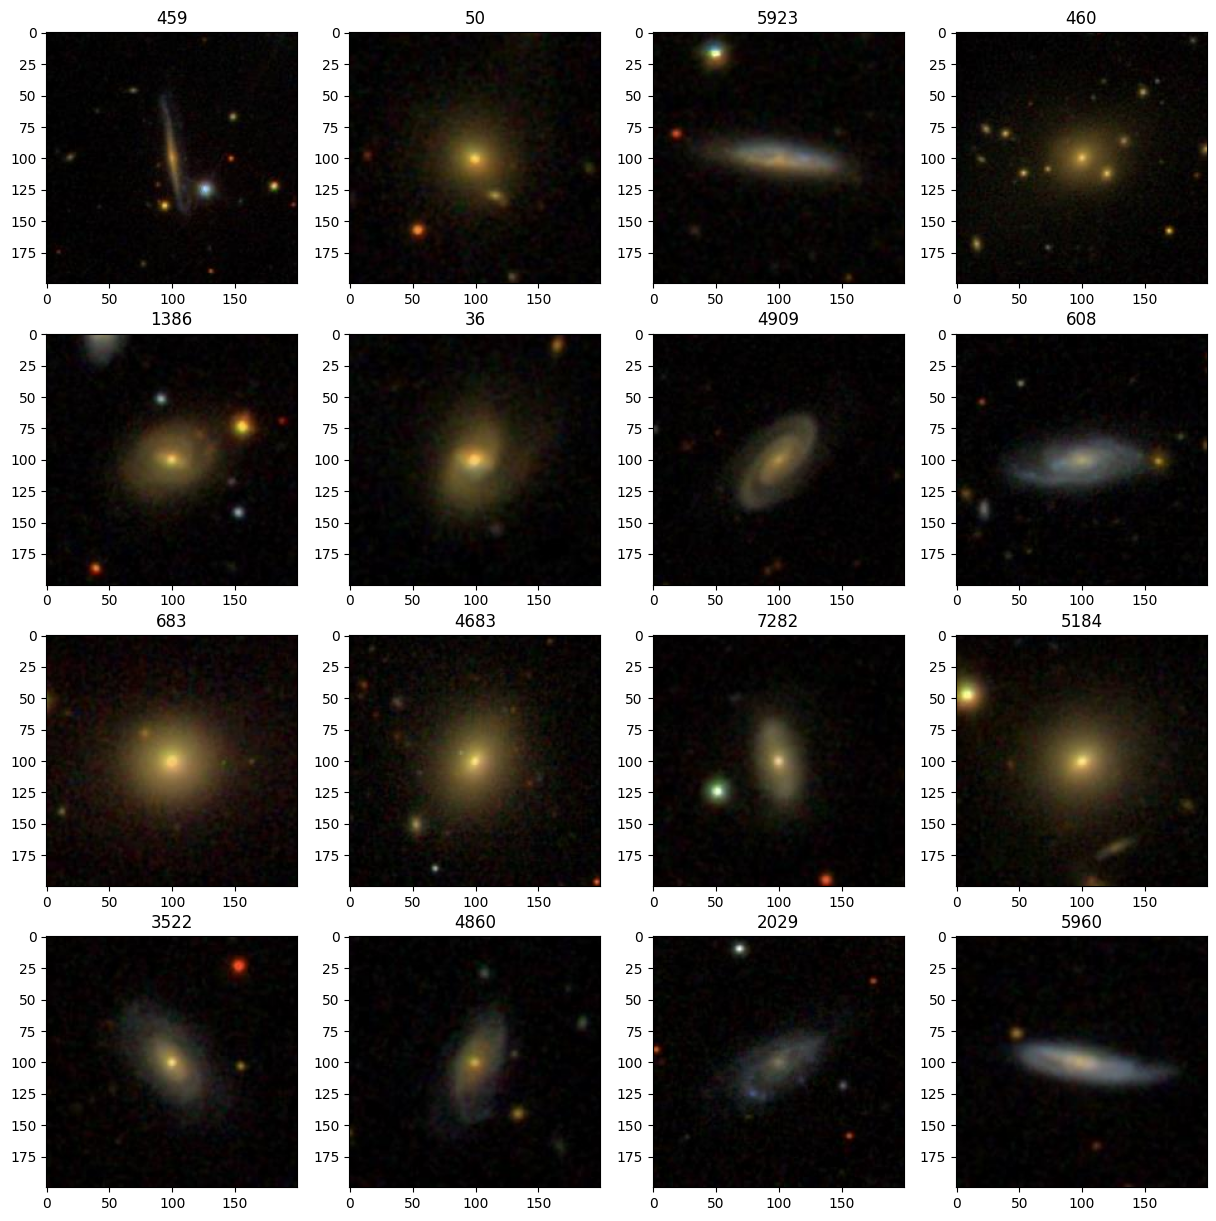

In [17]:
my_galaxies = np.where( (all_gals['z'] > 0.02) & (all_gals['z'] < 0.03))[0]
show_galaxy_images(my_galaxies)

### Exercise:
<b>Compute the fraction of galaxies you'd classify as spiral galaxies, and the fraction of galaxies you'd classify as being elliptical galaxies. </b>

Do this classification by eye.

If you want to improve your statistics, you can rerun the cell above and you will get 16 different galaxies every time...

<b>How to recognise the spiral galaxies? - They should look blueish, they should have a disk with some spiral or ring like structure.

How to recognise elliptical galaxies? - They should lool yellow or white and they should look smooth, whith no spiral or ring like structure.

Note: Some can be tricky and look somewhere inbetween the two categories. </b>

### Exercise:

Now do the same thing but taking 16 random galaxies that are **red**, according to your earlier definition of red and blue. Once again, classify the galaxies as disks or ellipticals.

Getting image 1 of 16...
Getting image 2 of 16...
Getting image 3 of 16...
Getting image 4 of 16...
Getting image 5 of 16...
Getting image 6 of 16...
Getting image 7 of 16...
Getting image 8 of 16...
Getting image 9 of 16...
Getting image 10 of 16...
Getting image 11 of 16...
Getting image 12 of 16...
Getting image 13 of 16...
Getting image 14 of 16...
Getting image 15 of 16...
Getting image 16 of 16...
Plotting images...


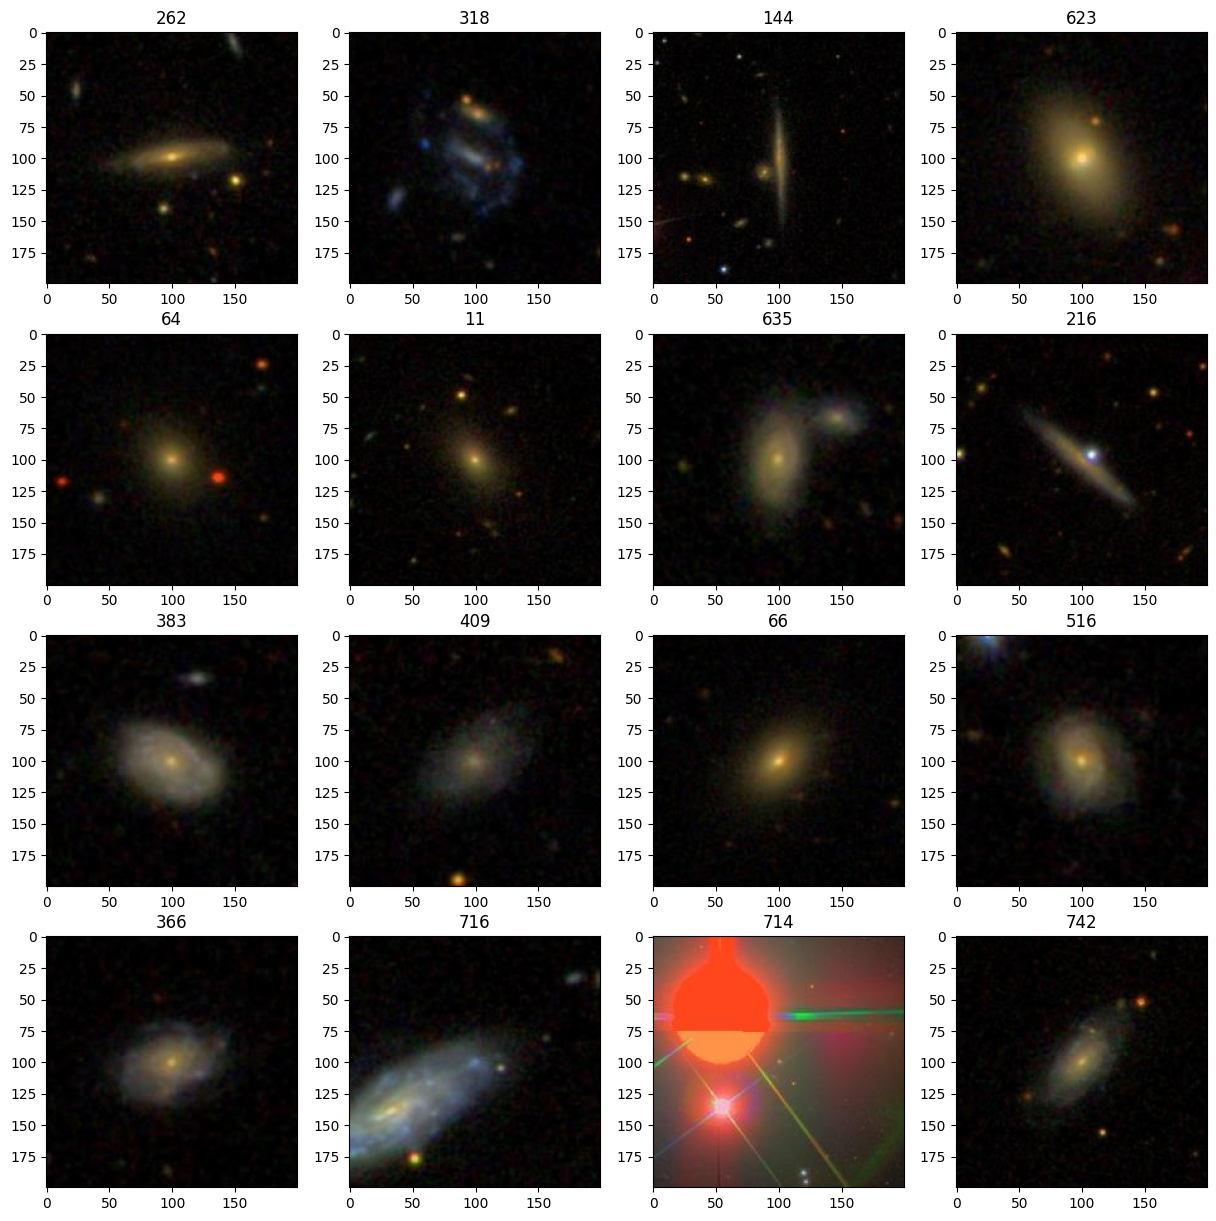

In [18]:
#possible answer

low_umg_2 = np.percentile(all_gals[slice1]['u']-all_gals[slice1]['g'], 10)
high_umg_2 = np.percentile(all_gals[slice1]['u']-all_gals[slice1]['g'], 90)

my_galaxies = np.where( (all_gals['z'] > 0.02) & (all_gals['z'] < 0.03) & (all_gals['u'] - all_gals['g'] > high_umg_2))[0]

show_galaxy_images(my_galaxies)

### Exercise:

Repeat the above exercise, now with blue galaxies. Repeat your classification exercise.

Getting image 1 of 16...
Getting image 2 of 16...
Getting image 3 of 16...
Getting image 4 of 16...
Getting image 5 of 16...
Getting image 6 of 16...
Getting image 7 of 16...
Getting image 8 of 16...
Getting image 9 of 16...
Getting image 10 of 16...
Getting image 11 of 16...
Getting image 12 of 16...
Getting image 13 of 16...
Getting image 14 of 16...
Getting image 15 of 16...
Getting image 16 of 16...
Plotting images...


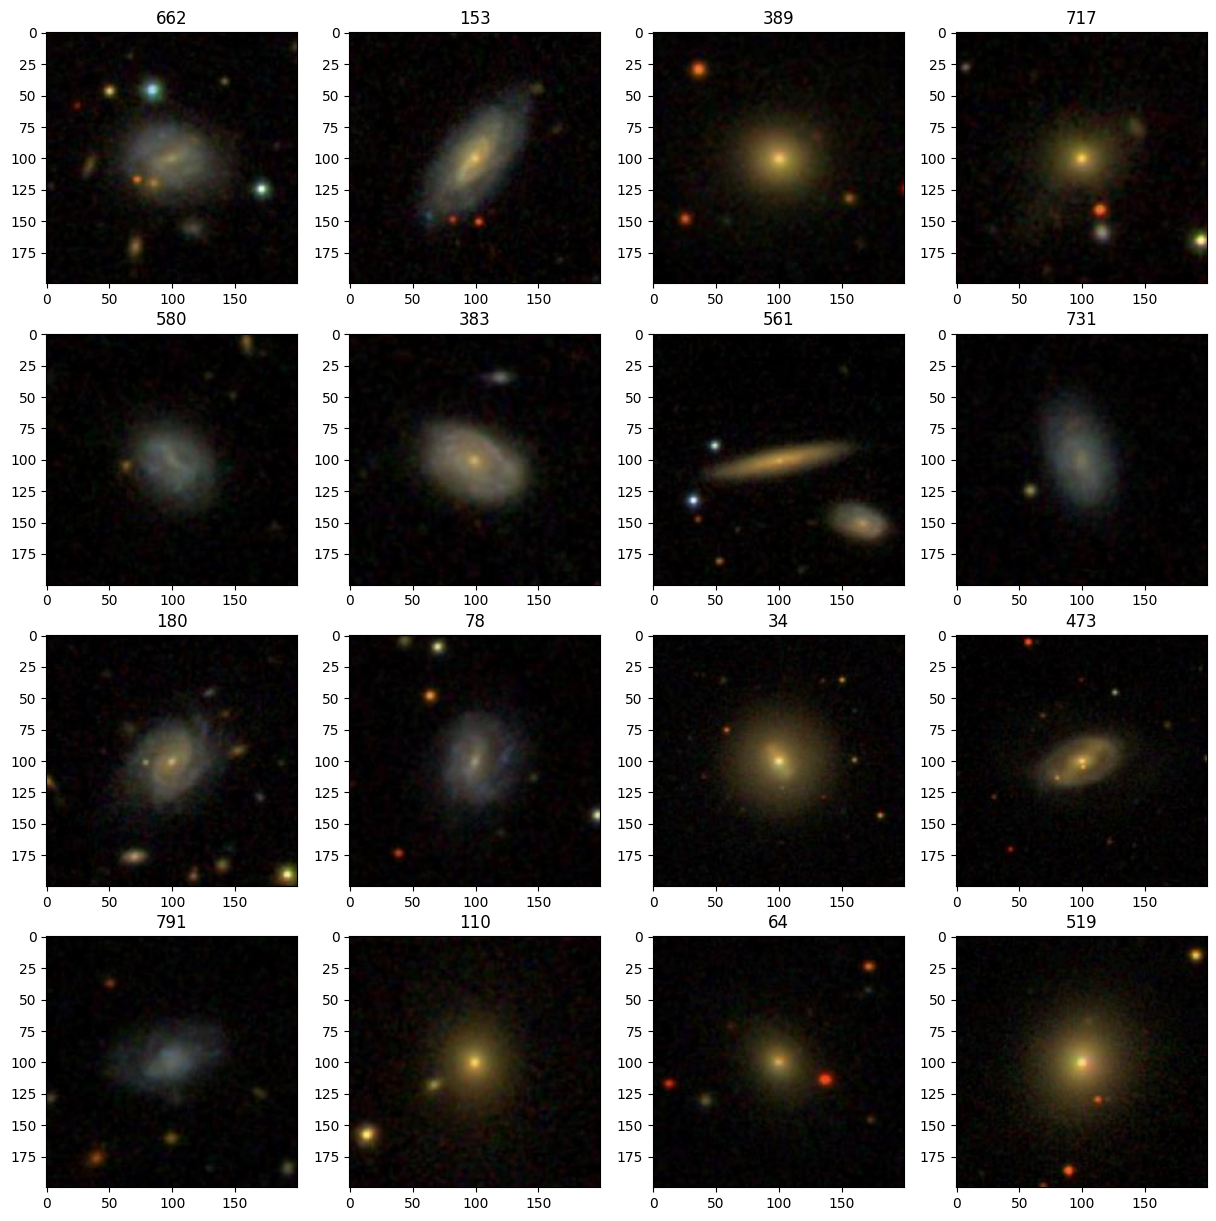

In [19]:
#possible answer
my_galaxies = np.where( (all_gals['z'] > 0.02) & (all_gals['z'] < 0.03) & (all_gals['u'] - all_gals['g'] < low_umg_2))[0]

show_galaxy_images(my_galaxies)

### Exercise:

From the above exercise, what can you say - if anything - about the relationship between colour and morphology?

Possible answer: Most blue galaxies are disc-like. Most red galaxies are bulge-dominated.


## Morphology and environment

Finally, we will explore the **relationship between morphology and environment**. It is extraordinarily difficult to write a computer programme that determines whether a galaxy has spiral structure or is smooth. To this day, the human eye does better than the most sophisticated algorithms (the reason behind projects such as Galaxy Zoo - https://www.galaxyzoo.org).

We will use a very simple proxy for morphology, which is good enough for our purposes: the sersic index. The sersic index tells us how rapidly the light profile of a galaxy is falling from the center, and essentially classifies galaxies' light profiles as being very centrally concentrated (like ellipticals), or as being flatter (like spirals).

<b>Massive elliptical galaxies have high Sérsic indices and a high degree of central concentration.

Discs of spiral galaxies have low Sérsic indices and a low degree of central concentration. </b>

The cell below repeats our initial SQL query, but now it also returns the sersic profile, called sersic_n, and we are already limiting the redshift range to be between 0.02 and 0.03.

In [20]:
# Create a query to fetch star forming galaxies

query = 'SELECT p.objId, p.ra, p.dec, p.petror90_r, p.expAB_r,'
query += 'p.dered_u as u, p.dered_g as g, p.dered_r as r, p.dered_i as i, ' # magnitudes or intensity of the galaxies
query += 's.z, s.plate, s.mjd, s.fiberid, n.sersic_n, n.sersic_flux_ivar_n '                      # sersic index
query += 'FROM galaxy AS p JOIN SpecObj AS s ON s.bestobjid = p.objid JOIN nsatlas AS n ON n.mjd = s.mjd and n.fiberID = s.fiberID and n.plate = s.plate '
query += 'WHERE '
query += 'p.petror90_r > 10 '
query += 'AND n.sersic_n < 5.8 '
query += 'AND sersic_flux_ivar_n < 0.5 '
query += 'AND p.ra between 100 and 250 '
query += 'AND s.z between 0.02 and 0.3 '
query += 'AND  p.g < 17 '

print (query) # useful for debugging

# send query to SDSS
all_gals_v2 = SDSS.query_sql(query, data_release=18)

all_gals_v2

SELECT p.objId, p.ra, p.dec, p.petror90_r, p.expAB_r,p.dered_u as u, p.dered_g as g, p.dered_r as r, p.dered_i as i, s.z, s.plate, s.mjd, s.fiberid, n.sersic_n, n.sersic_flux_ivar_n FROM galaxy AS p JOIN SpecObj AS s ON s.bestobjid = p.objid JOIN nsatlas AS n ON n.mjd = s.mjd and n.fiberID = s.fiberID and n.plate = s.plate WHERE p.petror90_r > 10 AND n.sersic_n < 5.8 AND sersic_flux_ivar_n < 0.5 AND p.ra between 100 and 250 AND s.z between 0.02 and 0.3 AND  p.g < 17 


<Table length=15623>
       objId               ra        ...  sersic_n sersic_flux_ivar_n
       int64            float64      ...  float64       float64      
------------------- ---------------- ... --------- ------------------
1237650762933862549 194.659404724726 ...  4.568267          0.3167589
1237657593541361825 128.786083209892 ...  1.333697          0.1083604
1237657594071023725 115.309764449323 ...  0.932183          0.3122234
1237657594071220539 115.572875238007 ...  2.653619          0.2512801
1237657594072399953  117.50009176143 ...  3.289677         0.08061835
1237657594072465514 117.604986686382 ...  1.482559         0.07398029
1237657594073448911 119.194125960948 ...   2.72604          0.3688274
1237658800966729761 194.680923866597 ...  5.106622          0.1186496
1237658800966926361 195.297268941935 ...  2.019815         0.05919454
1237658800966926419 195.321285197668 ...  4.748211          0.1276521
                ...              ... ...       ...                ...
1237668299276550246 181.832661038785 ...  1.665375         0.05682999
1237671262278385680 146.835376046548 ...  2.706744         0.09889767
1237671262280679529 152.200367644842 ...  1.218656          0.2142294
1237671262280810524 152.503888150477 ...  3.212621          0.2273809
1237671262281072874 153.192486081872 ...  1.026668          0.1076312
1237674288608772435 120.465847424167 ... 0.6181104          0.1977954
1237674288608968763  120.87058817533 ...  3.845968         0.02191245
1237674288609362211 122.096764970024 ... 0.9997863           0.324749
1237674288611328016 127.226347179444 ...  2.744233          0.1148611
1237674460951347308 138.315509188311 ...  4.387189          0.3756332


Below is a histogram of the values of the sersic index in our sample. Let us call galaxies with a very high sersic index ellipticals (n > 4), and a very low sersic index spirals (n < 2).

Text(0.5, 1.0, 'Distribution of Sersic index values')

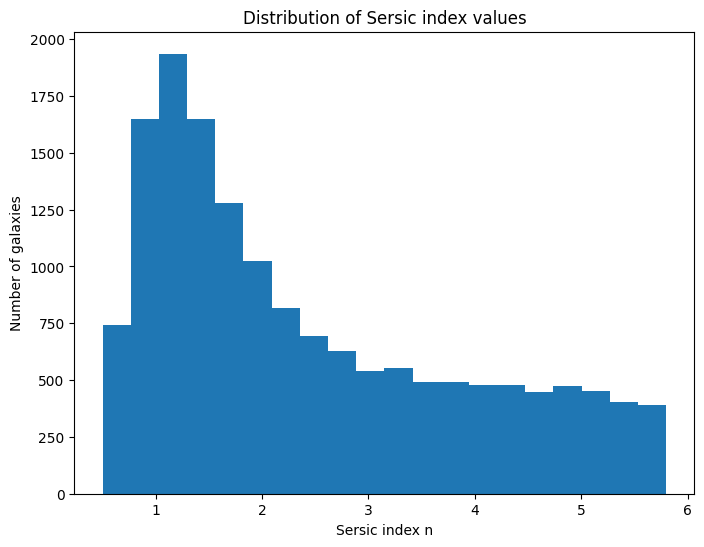

In [21]:
plt.figure(figsize=(8,6))
plt.hist(all_gals_v2['sersic_n'], bins=20)
plt.xlabel('Sersic index n')
plt.ylabel('Number of galaxies')
plt.title('Distribution of Sersic index values')

Text(0.5, 1.0, 'Distribution of Sersic index invariance')

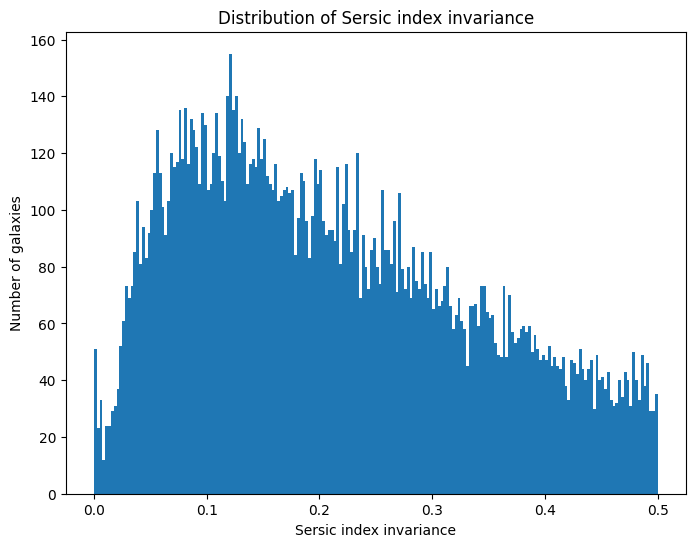

In [22]:
plt.figure(figsize=(8,6))
plt.hist(all_gals_v2['sersic_flux_ivar_n'], bins=200)
plt.xlabel('Sersic index invariance')
plt.ylabel('Number of galaxies')
plt.title('Distribution of Sersic index invariance')

### Exercise:

Look at the morphologies of high and low sersic index galaxies, like you did for blue and red. In your opinion, how good is this number at identifying morphology?

Getting image 1 of 16...
Getting image 2 of 16...
Getting image 3 of 16...
Getting image 4 of 16...
Getting image 5 of 16...
Getting image 6 of 16...
Getting image 7 of 16...
Getting image 8 of 16...
Getting image 9 of 16...
Getting image 10 of 16...
Getting image 11 of 16...
Getting image 12 of 16...
Getting image 13 of 16...
Getting image 14 of 16...
Getting image 15 of 16...
Getting image 16 of 16...
Plotting images...


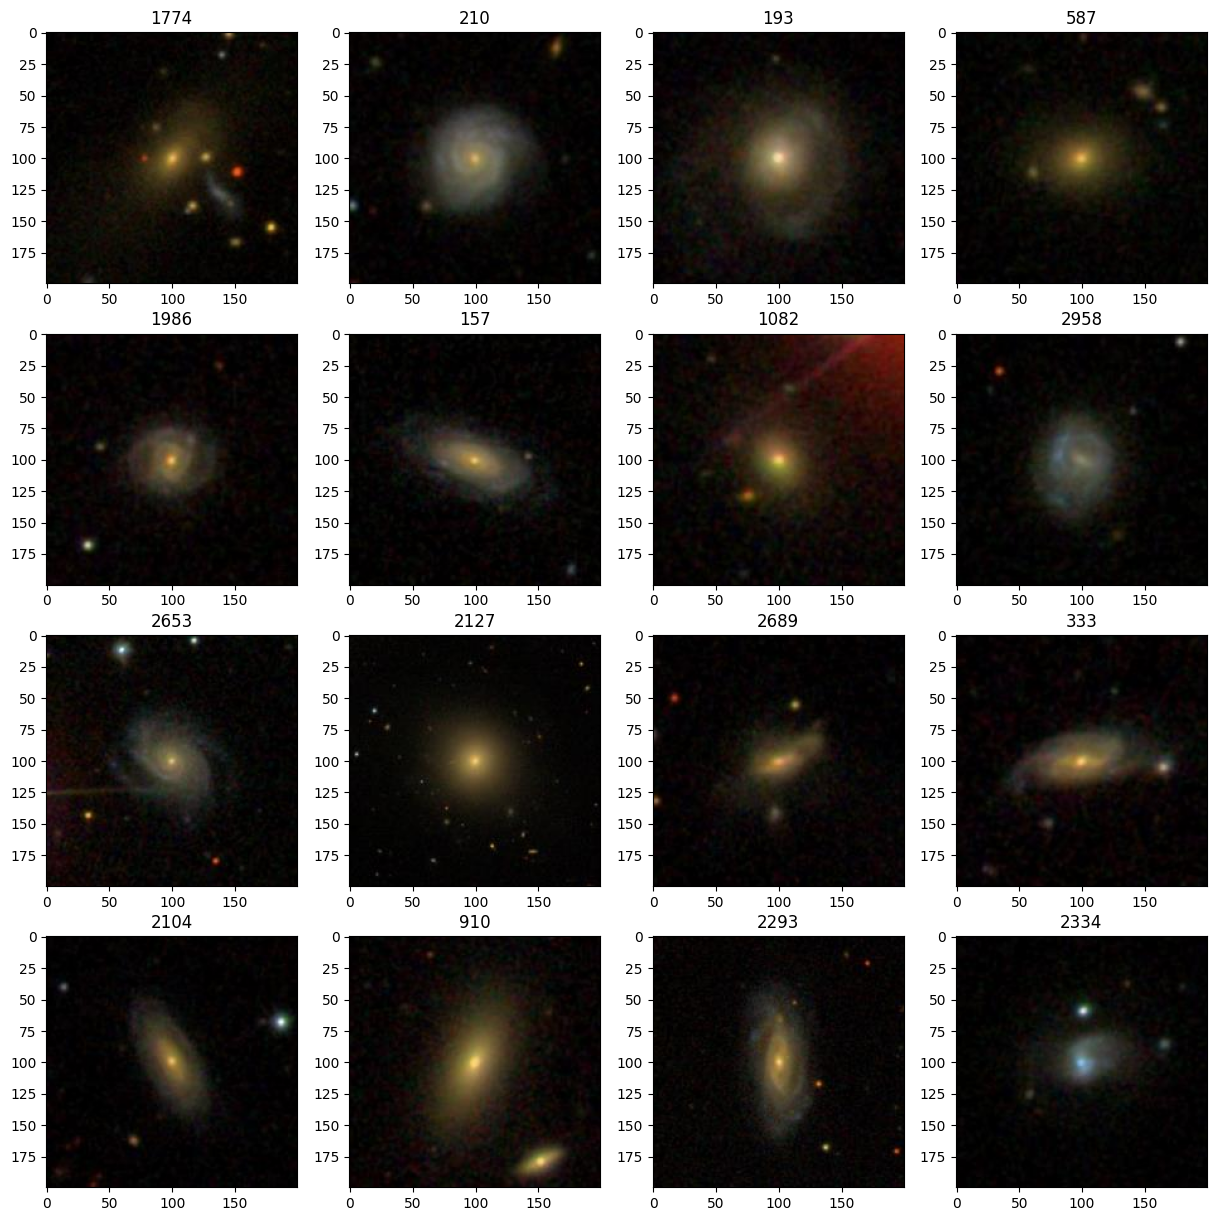

In [23]:
#possible answer
my_galaxies = np.where( (all_gals_v2['sersic_n'] > 4) )[0]

show_galaxy_images(my_galaxies)

Getting image 1 of 16...
Getting image 2 of 16...
Getting image 3 of 16...
Getting image 4 of 16...
Getting image 5 of 16...
Getting image 6 of 16...
Getting image 7 of 16...
Getting image 8 of 16...
Getting image 9 of 16...
Getting image 10 of 16...
Getting image 11 of 16...
Getting image 12 of 16...
Getting image 13 of 16...
Getting image 14 of 16...
Getting image 15 of 16...
Getting image 16 of 16...
Plotting images...


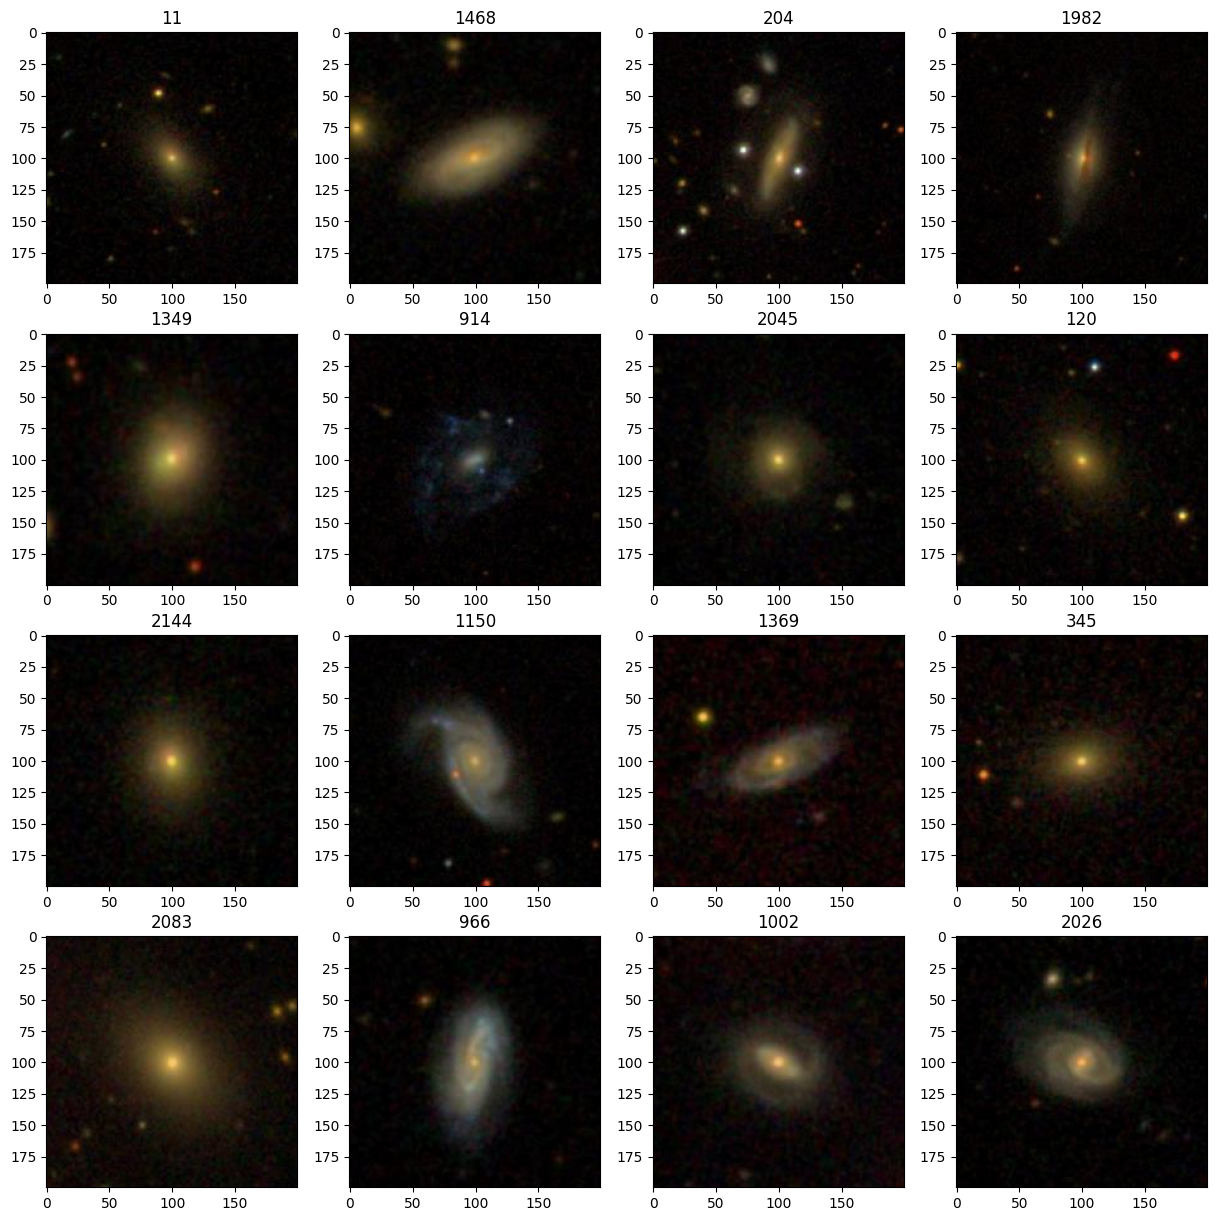

In [24]:
#possible answer
my_galaxies = np.where( (all_gals_v2['sersic_n'] < 1))[0]

show_galaxy_images(my_galaxies)

### Exercise:

Now plot the positions of low and high sersic index galaxies, side by side as you did for blue and red galaxies.

**In your opinion, do you have enough information to determine what property galaxy density influences the most (colour or morphology)?**

You are encouraged to experiment with different definitions of colour and morphology if you wish, or indeed make an argument as to why your exploration is insuffiencent to answer such a question.

(-5.0, 70.0)

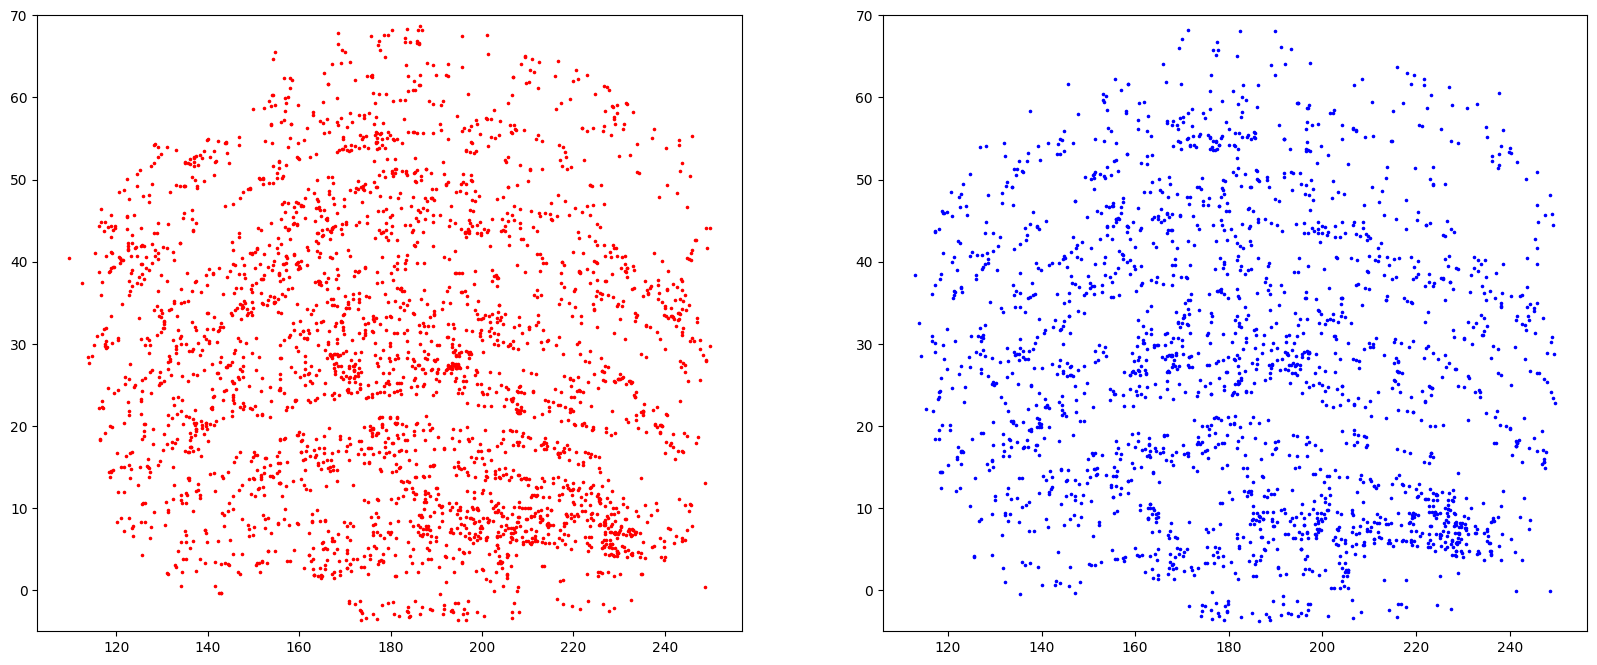

In [25]:
#possible answer
my_galaxies_ell = np.where( (all_gals_v2['sersic_n'] > 4))[0]
my_galaxies_sp = np.where( (all_gals_v2['sersic_n'] < 1))[0]

plt.figure(figsize=(20,8))
plt.subplot(121)
plt.scatter(all_gals[my_galaxies_ell]['ra'], all_gals[my_galaxies_ell]['dec'],  marker='.', s=10, color='red')
plt.ylim(-5,70)

plt.subplot(122)
plt.scatter(all_gals[my_galaxies_sp]['ra'], all_gals[my_galaxies_sp]['dec'],  marker='.', s=10, color='blue')
plt.ylim(-5,70)